In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import torch, torchvision
import torchvision.transforms as transforms

### Make sure your runtime type is either GPU or TPU

In [38]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


The list of class names in the dataset

In [25]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

torch.Size([128, 3, 32, 32]) torch.Size([128])
frog


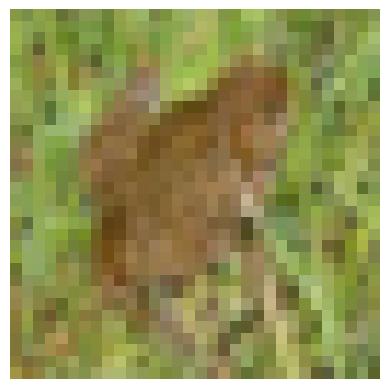

In [26]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.size(), labels.size())

i = 12
imshow(images[i].permute([1, 2, 0]).numpy()/2 + .5)
axis('off')
print(classes[labels[i].item()])



---



## Task 1
Build a neural network with two *Linear* layers and an output layer. The first Linear layer should have 512 neurons and the second 128 neurons. Both layers should use *relu* activation function. After each of these *Linear* layers, you should have a *dropout* layer (torch.nn.Dropout) with dropout probability 0.2. The output layer
should be a *Linear* layer.

Use torch.nn.CrossEntropyLoss to compute the loss value of the model output. Use *adam* optimizer to update the model parameters when training the model.

In [27]:
from torch import nn
device='cuda'
model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32,512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512,128),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(128,10)
    ).to(device)
learning_rate=1e-3
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


## Task 2
Train the model for 50 epochs. Evaluate the model on the testing data. Print out the model accuracy on test data after the training.

In [28]:
model.train()
epoch=50
for i in range(epoch):
    running_loss=0
    for batch,(X,y) in enumerate(trainloader):
        X,y=X.to(device), y.to(device)
        pred=model(X)
        loss=loss_fn(pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    epoch_loss=running_loss/(len(trainloader))
    print(f"Epoch: {i+1}, Training loss: {epoch_loss}")

Epoch: 1, Training loss: 1.7952626870416315
Epoch: 2, Training loss: 1.6381614174684296
Epoch: 3, Training loss: 1.5564458397648218
Epoch: 4, Training loss: 1.5113847444734305
Epoch: 5, Training loss: 1.4690861049515511
Epoch: 6, Training loss: 1.4310389440077955
Epoch: 7, Training loss: 1.3965321669493185
Epoch: 8, Training loss: 1.3693744633203881
Epoch: 9, Training loss: 1.3353116884255958
Epoch: 10, Training loss: 1.313000876885241
Epoch: 11, Training loss: 1.2875566767609639
Epoch: 12, Training loss: 1.2664261663051517
Epoch: 13, Training loss: 1.2431081594408626
Epoch: 14, Training loss: 1.225077635949225
Epoch: 15, Training loss: 1.1993863626819132
Epoch: 16, Training loss: 1.1803797497163953
Epoch: 17, Training loss: 1.1673101551087617
Epoch: 18, Training loss: 1.146930428264696
Epoch: 19, Training loss: 1.1312391927175205
Epoch: 20, Training loss: 1.1150607937742072
Epoch: 21, Training loss: 1.1037905159813668
Epoch: 22, Training loss: 1.08627060673121
Epoch: 23, Training loss

In [29]:
model.eval()
size=len(testloader.dataset)
num_batches=len(testloader)
test_loss,correct=0,0

with torch.no_grad():
    for X,y in testloader:
        X,y=X.to(device), y.to(device)
        pred=model(X)
        test_loss +=loss_fn(pred,y).item()
        correct += (pred.argmax(1)==y).type(torch.float).sum().item()

test_loss/=num_batches
correct/=size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 54.5%, Avg loss: 1.514689 



## Task 3
Implement a function *recognize*. It takes an image (shape = 3, 32, 32) as an input and use the "model" you trained above to make a prediction of the image's class. Your function should return the predicted (string) class (use the classes list above to map numeric prediction to string label).

torch.Size([3, 32, 32])
Neural network recognizes this image as: cat
true image label: cat


(-0.5, 31.5, 31.5, -0.5)

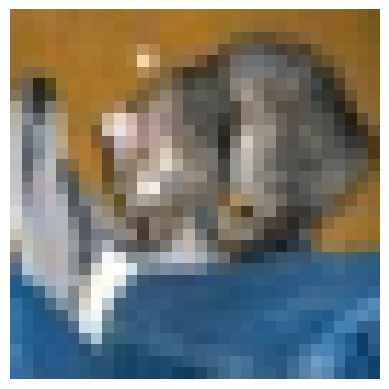

In [30]:
def recognize(new_img):
    model.eval()
    pred=model(new_img.view(1,3*32*32))
    prediction=pred.argmax(1)
    id=classes[prediction]

    return id


dataiter = iter(testloader)
images, labels = next(dataiter)
new_img = images[0]
print(new_img.size())

pred = recognize(new_img.cuda(0))

print('Neural network recognizes this image as:', pred)
print('true image label:', classes[labels[0].item()])
imshow(new_img.permute([1, 2, 0]).numpy()/2 + .5)
axis('off')

### Task 4

Implement a CNN with the following structure:
- 4 Conv layers:  
(3x3)x32, (3x3)x32, (3x3)x64, (3x3)x64

- 2x2 Maxpool after 2nd and 4th conv.
- Dropout after pooling
- One FC layer and then a FC output layer

Train the CNN model until training accuracy converges.
(Compute accuracy on training data at the end of each epoch. Plot the accuracy values vs epochs to determine whether it converges.) Test the accuracy of the trained model on the testing dataset.

In [39]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel,self).__init__()
        self.conv_layers=nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout2d(0.2),
            nn.Conv2d(32,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout2d(0.2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*5*5,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )

    def forward(self,x):
        x = self.conv_layers(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.fc_layer(x)
        return x

def train_loop(trainloader,model,loss_fn,optimizer,epochs):
    losses=[]
    accuracies=[]
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch,(X,y) in enumerate(trainloader):
            X,y=X.to(device),y.to(device)
            optimizer.zero_grad()
            pred=model(X)
            loss=loss_fn(pred,y)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            _, predicted = torch.max(pred, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
        epoch_loss=running_loss/len(trainloader)
        accuracy = 100 * correct / total
        losses.append(epoch_loss)
        accuracies.append(accuracy)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return losses,accuracies

def test_model(testloader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X,y in testloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    print(f"Accuracy on test set: {100 * correct / total:.2f}%")

model = ConvModel().to(device)
learning_rate=0.001
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


In [40]:
losses,accuracies=train_loop(trainloader,model,loss_fn,optimizer,50)

Epoch [1/50], Loss: 1.6435, Accuracy: 40.24%
Epoch [2/50], Loss: 1.2603, Accuracy: 55.18%
Epoch [3/50], Loss: 1.0800, Accuracy: 61.67%
Epoch [4/50], Loss: 0.9630, Accuracy: 66.26%
Epoch [5/50], Loss: 0.8761, Accuracy: 69.07%
Epoch [6/50], Loss: 0.8046, Accuracy: 71.92%
Epoch [7/50], Loss: 0.7474, Accuracy: 73.43%
Epoch [8/50], Loss: 0.6892, Accuracy: 75.79%
Epoch [9/50], Loss: 0.6430, Accuracy: 77.49%
Epoch [10/50], Loss: 0.5978, Accuracy: 79.00%
Epoch [11/50], Loss: 0.5507, Accuracy: 80.73%
Epoch [12/50], Loss: 0.5193, Accuracy: 81.63%
Epoch [13/50], Loss: 0.4885, Accuracy: 82.67%
Epoch [14/50], Loss: 0.4505, Accuracy: 83.87%
Epoch [15/50], Loss: 0.4183, Accuracy: 85.14%
Epoch [16/50], Loss: 0.4020, Accuracy: 85.71%
Epoch [17/50], Loss: 0.3722, Accuracy: 86.70%
Epoch [18/50], Loss: 0.3414, Accuracy: 87.96%
Epoch [19/50], Loss: 0.3293, Accuracy: 88.32%
Epoch [20/50], Loss: 0.3137, Accuracy: 88.82%
Epoch [21/50], Loss: 0.2965, Accuracy: 89.54%
Epoch [22/50], Loss: 0.2846, Accuracy: 89.8

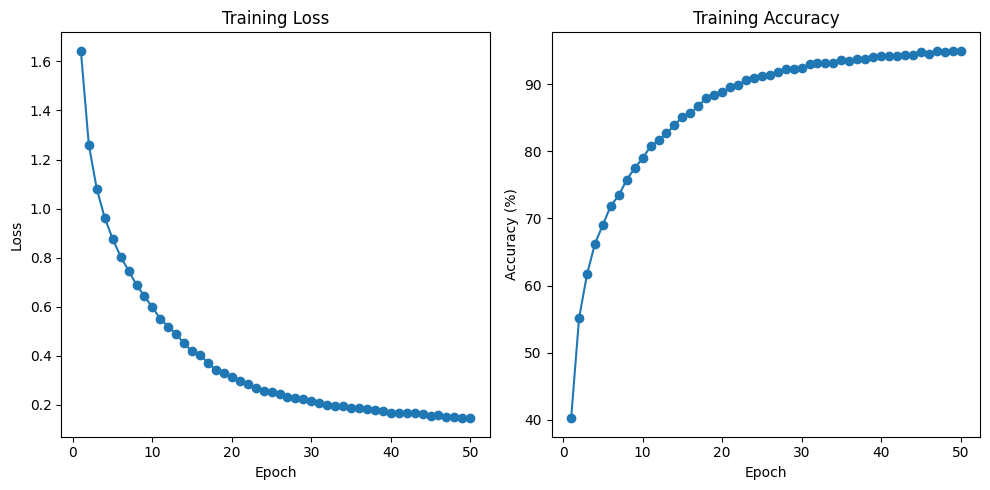

In [41]:
import matplotlib.pyplot as plt
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, '-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

In [42]:
test_model(testloader, model)


Accuracy on test set: 74.06%
